In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuness","key":"32df54c799f78dcc5a9992e952d632bb"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [8]:
!kaggle datasets download -d sohaibalam67/potato-disease

 75% 57.0M/75.7M [00:00<00:00, 67.3MB/s]
100% 75.7M/75.7M [00:00<00:00, 104MB/s] 


In [9]:
!mkdir potato

In [ ]:
!unzip potato-disease.zip -d potato

In [85]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [12]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=15

In [13]:
dataset=tf.keras.utils.image_dataset_from_directory("/content/potato/Potato",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [14]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
len(dataset)

68

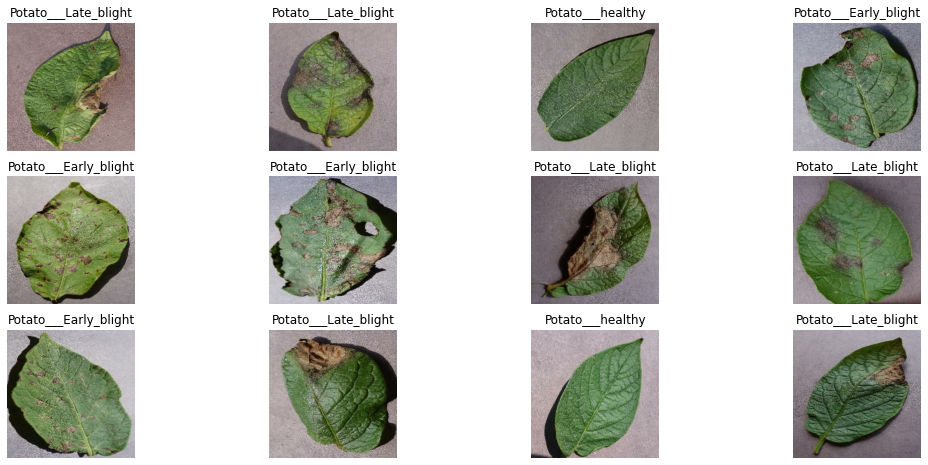

In [16]:
plt.figure(figsize=(18,8))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    lena=image_batch[i].numpy()
    laila=label_batch[i].numpy()
    plt.imshow(lena.astype('uint8'))
    plt.title(class_names[laila])
    plt.axis("off")

In [17]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds=dataset.take(516)
len(train_ds)

68

In [19]:
test_ds=dataset.skip(516)
len(test_ds)

0

In [20]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [21]:
val_ds=test_ds.take(64)
len(val_ds)

0

In [22]:
test_ds=test_ds.skip(64)
len(test_ds)

0

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [25]:
print(f"length of train dataset is :{len(train_ds)}")
print(f"length of validation dataset is :{len(val_ds)}")
print(f"length of test dataset is :{len(test_ds)}")

length of train dataset is :54
length of validation dataset is :6
length of test dataset is :8


In [26]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)   
])

In [28]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)   
])

In [29]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),   
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),      
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')                
])
model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
54/54 [==============================] - 202s 4s/step - loss: 0.9310 - accuracy: 0.4769 - val_loss: 0.8726 - val_accuracy: 0.4896
Epoch 2/15
54/54 [==============================] - 198s 4s/step - loss: 0.8690 - accuracy: 0.5341 - val_loss: 0.7513 - val_accuracy: 0.6354
Epoch 3/15
54/54 [==============================] - 195s 4s/step - loss: 0.6946 - accuracy: 0.6829 - val_loss: 0.5534 - val_accuracy: 0.7760
Epoch 4/15
54/54 [==============================] - 195s 4s/step - loss: 0.5631 - accuracy: 0.7402 - val_loss: 0.5432 - val_accuracy: 0.7656
Epoch 5/15
54/54 [==============================] - 202s 4s/step - loss: 0.3798 - accuracy: 0.8420 - val_loss: 0.4719 - val_accuracy: 0.8229
Epoch 6/15
54/54 [==============================] - 196s 4s/step - loss: 0.2990 - accuracy: 0.8895 - val_loss: 0.3747 - val_accuracy: 0.8281
Epoch 7/15
54/54 [==============================] - 195s 4s/step - loss: 0.2273 - accuracy: 0.9201 - val_loss: 0.1717 - val_accuracy: 0.9323
Epoch 8/15
54

In [33]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 10s 884ms/step - loss: 0.1730 - accuracy: 0.9375


In [34]:
scores

[0.1730027198791504, 0.9375]

In [35]:
history.params

{'epochs': 15, 'steps': 54, 'verbose': 1}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
history.history['accuracy']

[0.47685185074806213,
 0.5341435074806213,
 0.6828703880310059,
 0.7401620149612427,
 0.8420138955116272,
 0.8894675970077515,
 0.9201388955116272,
 0.9178240895271301,
 0.9502314925193787,
 0.9427083134651184,
 0.9670138955116272,
 0.9681712985038757,
 0.9664351940155029,
 0.9652777910232544,
 0.9635416865348816]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

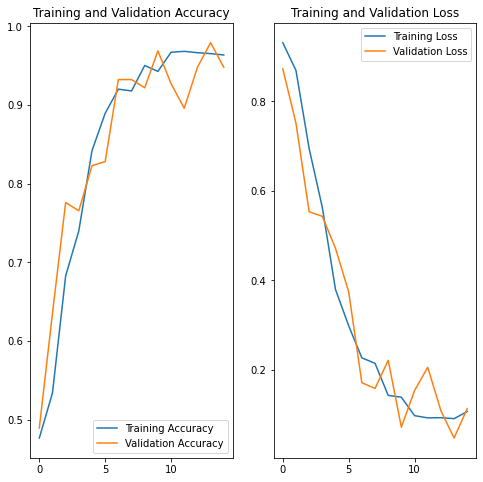

In [76]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label : Potato___Early_blight
predicted label : Potato___Early_blight


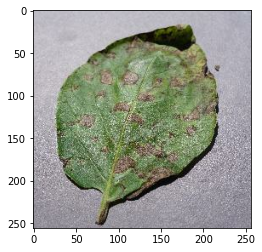

In [89]:
for images_batch , labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label :",class_names[first_label])
  batch_prediction=model.predict(images_batch)
  print("predicted label :" ,class_names[np.argmax(batch_prediction[0])])

In [90]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

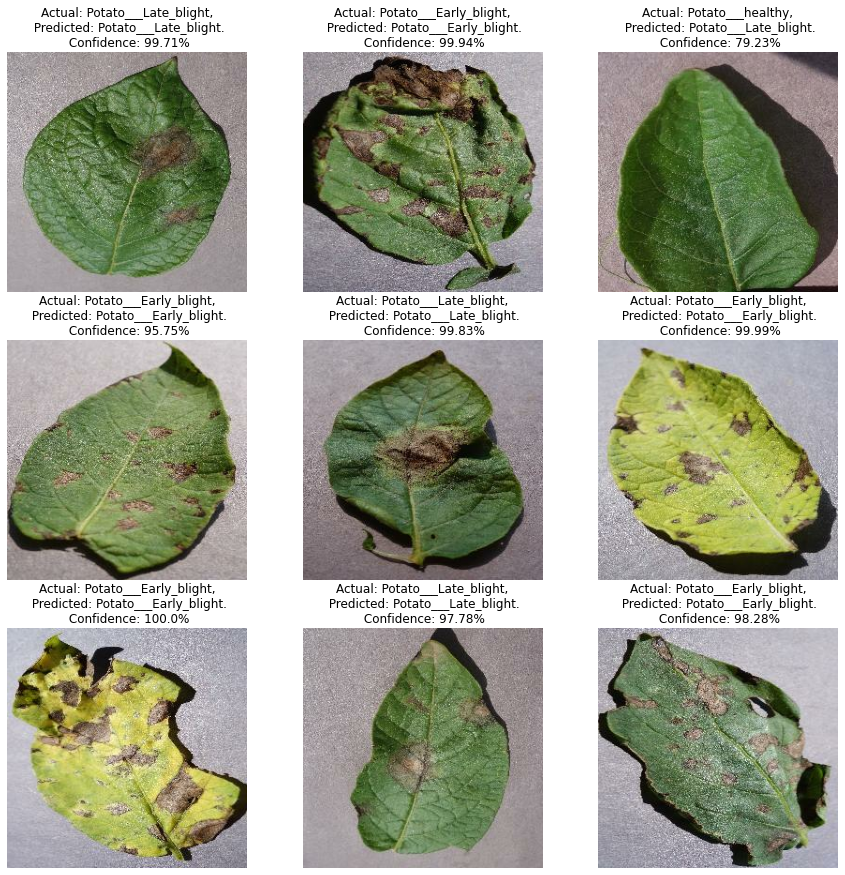

In [91]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [94]:
model.save("/content/potato/Potato")

INFO:tensorflow:Assets written to: /content/potato/Potato/assets
